In [3]:
import torch
# 检查 GPU 是否可用
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU 可用，正在使用 GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU 不可用，正在使用 CPU")


GPU 可用，正在使用 GPU: NVIDIA GeForce RTX 3060


In [4]:
sr=22050
n_mels=80
n_fft=1024
hop_length=256

In [11]:

import os
import librosa
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np
class AudioTextDataset(Dataset):
    def __init__(self, audio_dir, text_file, text_max_length, sr=22050, n_mels=80, n_fft=1024, hop_length=256):
        self.audio_dir = audio_dir
        self.max_length = text_max_length
        self.sr = sr
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.hop_length = hop_length

        self.audio_files = sorted([f for f in os.listdir(audio_dir) if f.endswith(".mp3")])
        with open(text_file, "r", encoding="utf-8") as f:
            self.texts = [line.split('|')[0] for line in f]

        assert len(self.audio_files) == len(self.texts), "音频文件和文本文件数量不匹配！"
        self.vocab = sorted(set("".join(self.texts)))

        # 加载音频并提取 Mel Spectrogram
        self.mel_spectrograms = []
        for audio_file in self.audio_files:
            audio_path = os.path.join(self.audio_dir, audio_file)
            audio, _ = librosa.load(audio_path, sr=self.sr)
            mel_spectrogram = librosa.power_to_db(librosa.feature.melspectrogram(
                y=audio, sr=self.sr, n_mels=self.n_mels, n_fft=self.n_fft, hop_length=self.hop_length
            ), ref=np.max, top_db=80)
            self.mel_spectrograms.append(torch.Tensor(mel_spectrogram).to(device))

        # 文本编码和填充
        self.text_tensors = []
        for text in self.texts:
            text_tensor = torch.LongTensor([self.vocab.index(char) for char in text])
            text_tensor = self._pad_or_truncate(text_tensor)
            self.text_tensors.append(text_tensor.to(device))

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        # mel_spectrogram = self.mel_spectrograms[idx]

        # text_tensor = self.text_tensors[idx]

        #print("mel_spectrogram.shape",mel_spectrogram.shape,"text_tensor.shape",text_tensor.shape,"mel_spectrogram.shape[1]",mel_spectrogram.shape[1] )
        return self.text_tensors[idx],self.mel_spectrograms[idx]

    def _pad_or_truncate(self, sequence):
        seq_length = len(sequence)
        if seq_length < self.max_length:
            return torch.cat((sequence, torch.zeros(self.max_length - seq_length, dtype=torch.long)))
        elif seq_length > self.max_length:
            return sequence[: self.max_length]
        return sequence

# 设置数据路径和参数
audio_dir = "/home/robot22/SD/TTS/train_data" 
text_dir = "/home/robot22/SD/TTS/label_list.txt"  
text_max_len = 68 
batch_size = 8
# 创建数据集和 DataLoader
dataset = AudioTextDataset(audio_dir, text_dir, text_max_len)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [133]:
import librosa
import numpy as np

audio_path = "/home/robot22/SD/TTS/train_data/output32.mp3"
sr = 22050
n_mels = 80
n_fft = 1024
hop_length = 256

audio, _ = librosa.load(audio_path, sr=sr)
audio = audio *10

# 打印音频信息
print("Audio shape:", audio.shape)
print("Audio max:", audio.max())
print("Audio min:", audio.min())

# 计算 Mel 频谱图
S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length,  power=1.5)

# 打印 Mel 频谱图信息 (线性刻度)
print("\nMel spectrogram shape (linear):", S.shape)
print("Mel spectrogram max (linear):", S.max())
print("Mel spectrogram min (linear):", S.min())

# 转换为 dB 刻度
mel_spectrogram = librosa.power_to_db(S, ref=np.max,top_db=80)

# 打印 Mel 频谱图信息 (dB 刻度)
print("\nMel spectrogram shape (dB):", mel_spectrogram.shape)
print("Mel spectrogram max (dB):", mel_spectrogram.max())
print("Mel spectrogram min (dB):", mel_spectrogram.min())


Audio shape: (771749,)
Audio max: 3.3256054
Audio min: -3.4680195

Mel spectrogram shape (linear): (80, 3015)
Mel spectrogram max (linear): 321.94998
Mel spectrogram min (linear): 0.0

Mel spectrogram shape (dB): (80, 3015)
Mel spectrogram max (dB): 0.0
Mel spectrogram min (dB): -80.0


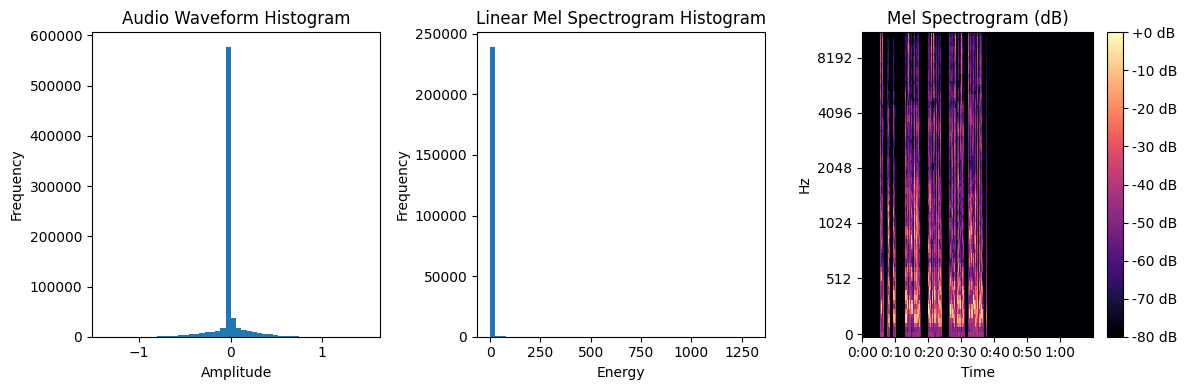

In [93]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

audio_path = "/home/robot22/SD/TTS/train_data/output22.mp3"
sr = 22050
n_mels = 80
n_fft = 1024
hop_length = 256

# 加载音频
audio, _ = librosa.load(audio_path, sr=sr)
audio = audio*5
# 计算 Mel 频谱图
S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
mel_spectrogram = librosa.power_to_db(S, ref=np.max)

# 绘制音频波形直方图
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(audio, bins=50)
plt.title('Audio Waveform Histogram')
plt.xlabel('Amplitude')
plt.ylabel('Frequency')

# 绘制线性 Mel 频谱图直方图
plt.subplot(1, 3, 2)
plt.hist(S.flatten(), bins=50)
plt.title('Linear Mel Spectrogram Histogram')
plt.xlabel('Energy')
plt.ylabel('Frequency')

# 绘制 dB Mel 频谱图
plt.subplot(1, 3, 3)
librosa.display.specshow(mel_spectrogram, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram (dB)')

plt.tight_layout()
plt.show()





In [107]:
import soundfile as sf  # 导入 soundfile 库
mel_spectrogram = dataset[0][1].numpy()
# 使用 Griffin-Lim 算法从梅尔频谱图重建音频
audio_reconstructed = librosa.feature.inverse.mel_to_audio(
    mel_spectrogram, sr=sr, n_fft=n_fft, hop_length=hop_length
)
audio = audio.T  # 转置矩
sf.write("reconstructed_audio1.wav", audio.astype(np.float32), sr, format='WAV')  # 使用 sf.write 保存音频
# 保存重建的音频


In [97]:
torch.max(dataset[0][1]),torch.min(dataset[0][1]),dataset[0][1]


(tensor(0.),
 tensor(-80.),
 tensor([[-80., -80., -80.,  ..., -80., -80., -80.],
         [-80., -80., -80.,  ..., -80., -80., -80.],
         [-80., -80., -80.,  ..., -80., -80., -80.],
         ...,
         [-80., -80., -80.,  ..., -80., -80., -80.],
         [-80., -80., -80.,  ..., -80., -80., -80.],
         [-80., -80., -80.,  ..., -80., -80., -80.]]))

In [74]:
audio, _ = librosa.load("/home/robot22/SD/TTS/train_data/output32.mp3", sr=22050)
print(audio.max(), audio.min())

0.33256054 -0.34680194


mel_spectrogram.shape torch.Size([80, 3015]) text_tensor.shape torch.Size([68]) mel_spectrogram.shape[1] 3015


In [12]:
import torch
import torch.nn as nn
from tqdm import tqdm

class LSTMEncoderDecoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, enc_hidden_dim,batch_size):
        super(LSTMEncoderDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim*text_max_len, enc_hidden_dim, batch_first=True)
        self.mlp = nn.Sequential(
            nn.Linear(1, 80),
            nn.Sigmoid(),
            nn.Linear(80, 80)
        )
        self.batch_size = batch_size

        # 用于残差连接的线性层，如果输入输出维度不同，则需要进行维度调整
        # self.linear_shortcut = nn.Linear(embedding_dim*text_max_len, enc_hidden_dim) 

    def forward(self, text):
        embedded_text = self.embedding(text)
        embedded_text = embedded_text.view(self.batch_size, -1)#  batch_size

        #print("embedded_text.shape",embedded_text.shape)
        output, _ = self.lstm(embedded_text)  # [batch_size, text_length, hidden_dim]
        #print("output.shape",output.shape)
        output = output.unsqueeze(2)
        #print("output.unsqueeze(1).shape",output.shape)        
        output = self.mlp(output) # + self.linear_shortcut(embedded_text)  
        return output

# 模型实例化
vocab_size = 653
embedding_dim = 32
enc_hidden_dim = 3015
output_dim = 80

model = LSTMEncoderDecoder(vocab_size, embedding_dim, enc_hidden_dim,batch_size).to(device)
# 损失函数和优化器
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.AdamW(model.parameters())

# 训练循环
num_epochs = 900
for epoch in range(num_epochs):
    loop = tqdm(dataloader, leave=True)
    for batch_idx, (data, target) in enumerate(loop):
        # data,target  = data.to(device), target.to(device)  # 将数据移动到设备
        target = target.view(target.size(0), -1, target.size(1)) # 交换维度，形状变为 (batch_size, 1, seq_len)


        #print("text_tensors.shape",text_tensors.shape)
        # 前向传播
        output = model(data)

        # 计算损失
        # print("output",output.shape,"target",target.shape)

        loss = criterion(output, target)

        # 清空梯度
        optimizer.zero_grad()

        # 反向传播
        loss.backward()

        # 更新模型参数
        optimizer.step()

        # 打印训练信息
 
        # 4. 更新 tqdm 进度条
        loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        loop.set_postfix(loss=loss.item()) 

# 保存训练好的模型
torch.save(model.state_dict(), "tts_model.pth")



Epoch [900/900]: 100%|██████████| 6/6 [00:00<00:00, 32.01it/s, loss=3.04e+8]


In [7]:
model.batch_size = 8
# 训练循环
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-5)
criterion = nn.MSELoss(reduction='sum')
num_epochs = 500
for epoch in range(num_epochs):
    loop = tqdm(dataloader, leave=True)
    for batch_idx, (data, target) in enumerate(loop):
        data,target  = data.to(device), target.to(device)  # 将数据移动到设备
        target = target.view(target.size(0), -1, target.size(1)) # 交换维度，形状变为 (batch_size, 1, seq_len)


        #print("text_tensors.shape",text_tensors.shape)
        # 前向传播
        output = model(data)

        # 计算损失
        # print("output",output.shape,"target",target.shape)

        loss = criterion(output, target)

        # 清空梯度
        optimizer.zero_grad()

        # 反向传播
        loss.backward()

        # 更新模型参数
        optimizer.step()

        # 打印训练信息
 
        # 4. 更新 tqdm 进度条
        # if epoch % 1000 == 0:
        #     loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        #     loop.set_postfix(loss=loss.item()) 

# 保存训练好的模型
torch.save(model.state_dict(), "tts_model_pro.pth")


100%|██████████| 6/6 [00:00<00:00, 36.11it/s]


In [13]:
test_text = "静夜思  唐  李白  床前明月光，疑是地上霜。举头望明月，低头思故乡。"

In [14]:

model.batch_size = 1

# 音频生成
with torch.no_grad():
    # 输入文本
    test_text_tensor = torch.LongTensor([dataset.vocab.index(char) for char in test_text])# [self.vocab.index(char) for char in self.texts[idx]]

    test_text_tensor = dataset._pad_or_truncate(test_text_tensor).unsqueeze(0).to(device)

    # 模型预测
    predicted_mel_spec = model(test_text_tensor)

    predicted_mel_spec = torch.transpose(predicted_mel_spec, 1, 2).cpu().numpy()


In [15]:
import soundfile as sf  # 导入 soundfile 库

# 使用 Griffin-Lim 算法从梅尔频谱图重建音频
audio_reconstructed = librosa.feature.inverse.mel_to_audio(
    predicted_mel_spec, sr=sr, n_fft=n_fft, hop_length=hop_length
)
audio_reconstructed = audio_reconstructed.T  # 转置矩


sf.write("reconstructed_audio_baseline.wav", audio_reconstructed.astype(np.float32), sr, format='WAV')  # 使用 sf.write 保存音频
# 保存重建的音频


In [45]:
mel_spectrogram = librosa.db_to_power(predicted_mel_spec.cpu().numpy())
# 使用 Griffin-Lim 算法或其他声码器生成音频
audio_waveform =  librosa.griffinlim(mel_spectrogram ,n_fft=1024, hop_length=256, n_iter=32)

In [60]:
import soundfile as sf  # 导入 soundfile 库

linear_spectrogram = librosa.feature.inverse.mel_to_stft(
    mel_spectrogram, sr=sr, n_fft=n_fft
)
# 使用Griffin-Lim算法估计相位信息
audio = librosa.griffinlim(
    linear_spectrogram, n_iter=32, hop_length=256
)
audio = audio.T  # 转置矩
sf.write("reconstructed_audio.wav", audio.astype(np.float32), sr, format='WAV')  # 使用 sf.write 保存音频

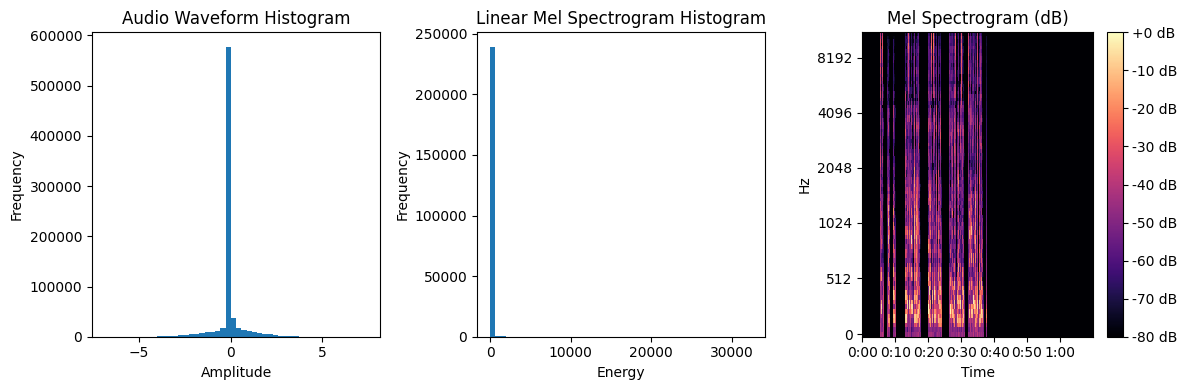

In [126]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

sr = 22050
n_mels = 80
n_fft = 1024
hop_length = 256

# 加载音频
audio = audio*5
# 计算 Mel 频谱图
S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
mel_spectrogram = librosa.power_to_db(S, ref=np.max)

# 绘制音频波形直方图
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(audio, bins=50)
plt.title('Audio Waveform Histogram')
plt.xlabel('Amplitude')
plt.ylabel('Frequency')

# 绘制线性 Mel 频谱图直方图
plt.subplot(1, 3, 2)
plt.hist(S.flatten(), bins=50)
plt.title('Linear Mel Spectrogram Histogram')
plt.xlabel('Energy')
plt.ylabel('Frequency')

# 绘制 dB Mel 频谱图
plt.subplot(1, 3, 3)
librosa.display.specshow(mel_spectrogram, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram (dB)')

plt.tight_layout()
plt.show()



